<a href="https://colab.research.google.com/github/inaG17/AllSQL/blob/main/This_is_the_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from imblearn.over_sampling import RandomOverSampler

In [ ]:
!pip install XGBoost
!pip install CatBoost

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# Load the datasets
train_data_path = 'credit_data_train.csv'
test_data_path = 'credit_data_test.csv'
sample_submission_path = 'sample_submission.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
sample_submission = pd.read_csv(sample_submission_path)

In [ ]:
# Impute missing values for 'age' using the median
imputer = SimpleImputer(strategy='median')
train_data['age'] = imputer.fit_transform(train_data[['age']])

# Identify categorical and numerical columns
categorical_cols = train_data.select_dtypes(include=['object', 'bool']).columns
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop('class')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Apply preprocessing to the training data
X_train = preprocessor.fit_transform(train_data.drop('class', axis=1))
y_train = train_data['class'].values

# Apply the same preprocessing to the test data
X_test = preprocessor.transform(test_data)

(X_train.shape, y_train.shape, X_test.shape)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# Perform cross-validation to evaluate the model's performance
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training data
rf_classifier.fit(X_train, y_train)

# Cross-validation scores
cv_scores.mean(), cv_scores.std()

(0.7950411668045596, 0.04395628450752299)

In [ ]:
# Define a smaller grid of hyperparameters to search
small_param_grid = {
    'n_estimators': [100, 150],  # fewer options
    'max_depth': [None, 20],  # fewer options
    'min_samples_split': [2, 5],  # fewer options
    'min_samples_leaf': [1, 2]  # fewer options
}

# Initialize the Grid Search with cross-validation, this time with a smaller grid
small_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=small_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Perform the grid search on the training data
small_grid_search.fit(X_train, y_train)

# Best parameters and best score from the smaller grid search
small_best_params = small_grid_search.best_params_
small_best_score = small_grid_search.best_score_

(small_best_params, small_best_score)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


({'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 150},
 0.7962294720816051)

In [ ]:
# Train a new Random Forest classifier with the best parameters from the grid search
optimized_rf_classifier = RandomForestClassifier(
    n_estimators=small_best_params['n_estimators'],
    max_depth=small_best_params['max_depth'],
    min_samples_split=small_best_params['min_samples_split'],
    min_samples_leaf=small_best_params['min_samples_leaf'],
    random_state=0
)

# Perform cross-validation to evaluate the optimized model's performance
optimized_cv_scores = cross_val_score(optimized_rf_classifier, X_train, y_train, cv=5, scoring='roc_auc')

# Train the optimized model on the entire training data
optimized_rf_classifier.fit(X_train, y_train)

# Cross-validation scores for the optimized model
optimized_cv_scores.mean(), optimized_cv_scores.std()


(0.7885077679720537, 0.04257446600842665)

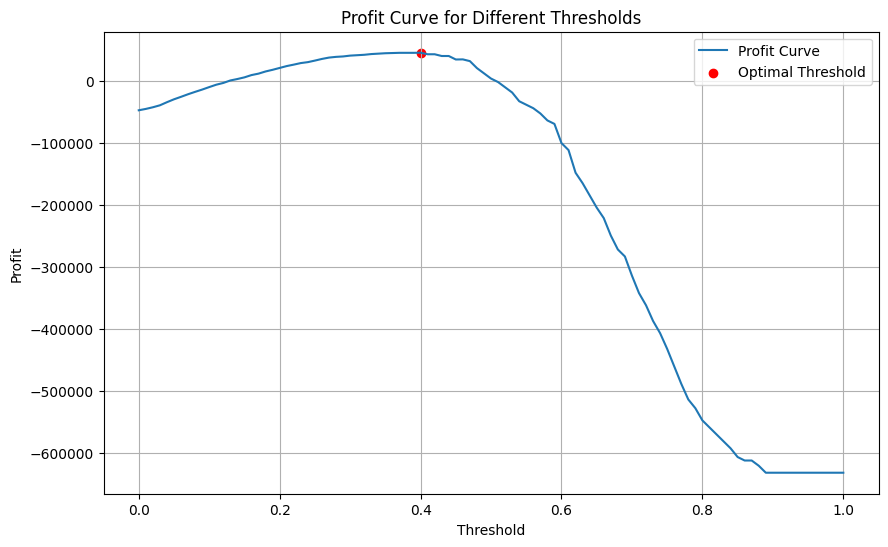

(0.4, 46189.11488765001)

In [ ]:
# Assumptions based on the example provided
average_loan_value = 2814.646  # average loan amount
interest_rate = 0.029675  # assumed interest rate for TN
interest_income = average_loan_value * interest_rate  # benefit of TN

# The cost of FP is assumed to be the loss of the entire loan amount
cost_of_fp = average_loan_value

# The cost of FN is assumed to be the lost interest income
cost_of_fn = interest_income

# Calculate the benefit for TP which is avoiding the loss of the loan amount (same as cost of FP)
benefit_of_tp = interest_income

# No actual benefit for TN since it is the expected scenario, but we avoid cost of FN
benefit_of_tn = 0

# Function to calculate the total profit based on a decision threshold
def calculate_profit(thresholds, probabilities, true_values):
    profits = []
    for threshold in thresholds:
        # Make predictions based on the threshold
        predictions = (probabilities >= threshold).astype(int)

        # Calculate confusion matrix components
        TP = np.sum((predictions == 0) & (true_values == 0))
        FP = np.sum((predictions == 0) & (true_values == 1))
        TN = np.sum((predictions == 1) & (true_values == 1))
        FN = np.sum((predictions == 1) & (true_values == 0))

        # Calculate total profit
        total_profit = (TP * benefit_of_tp) + (TN * benefit_of_tn) - (FP * cost_of_fp) - (FN * cost_of_fn)
        profits.append(total_profit)

    return profits

# We'll use the training set probabilities and true values for this analysis
train_probabilities = optimized_rf_classifier.predict_proba(X_train)[:, 1]
train_true_values = y_train

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 101)

# Calculate profits for each threshold
profits = calculate_profit(thresholds, train_probabilities, train_true_values)

# Find the threshold with the maximum profit
max_profit = max(profits)
optimal_threshold = thresholds[profits.index(max_profit)]
#optimal_threshold=0.38
# Plot the profit curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label='Profit Curve')
plt.scatter(optimal_threshold, max_profit, color='red', label='Optimal Threshold')
plt.title('Profit Curve for Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()

optimal_threshold, max_profit

In [ ]:
# Feature Engineering: Creating a Debt-to-Income ratio (DTI) and categorizing 'length_of_employment'

# Since we don't have the income data, we'll make a simplified assumption for demonstration
# We'll assume that the 'loan_value' can serve as a proxy for debt and that the
# 'instalment_rate' (which is a percentage of disposable income) can serve as a proxy for income
# Define bins for the age feature
age_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95-104']
train_data['age_binned'] = pd.cut(train_data['age'], bins=age_bins, labels=age_labels, include_lowest=True)


# Apply the same binning to the test set
test_data['age_binned'] = pd.cut(test_data['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Calculate a proxy Debt-to-Income ratio: (loan_value / instalment_rate)
# We will handle the division by zero by replacing inf values with a large number
train_data['DTI_proxy'] = train_data['loan_value'] / (train_data['instalment_rate'] / 100)
test_data['DTI_proxy'] = test_data['loan_value'] / (test_data['instalment_rate'] / 100)
train_data['DTI_proxy'].replace([np.inf, -np.inf], np.max(train_data['DTI_proxy']), inplace=True)
test_data['DTI_proxy'].replace([np.inf, -np.inf], np.max(test_data['DTI_proxy']), inplace=True)

# Categorizing 'length_of_employment' into bins
employment_length_bins = [-1, 0, 1, 4, 7, 10, 100]  # -1 for unemployed, 0 for <1 year, 1-4, 4-7, 7-10, >10 years
employment_length_labels = ['unemployed', '<1', '1-4', '4-7', '7-10', '>10']
train_data['employment_length_binned'] = pd.cut(train_data['length_of_employment'].map({'Unemployed': -1, '< 1 year': 0.5, '1-4 years': 2.5, '4-7 years': 5.5, '>= 7 years': 10}), bins=employment_length_bins, labels=employment_length_labels)
test_data['employment_length_binned'] = pd.cut(test_data['length_of_employment'].map({'Unemployed': -1, '< 1 year': 0.5, '1-4 years': 2.5, '4-7 years': 5.5, '>= 7 years': 10}), bins=employment_length_bins, labels=employment_length_labels)

# Correcting the previous error, we don't need to convert numerical_cols_updated to a list since it's already one.
# Now, we will update the preprocessor with the newly engineered features.
numerical_cols_updated = numerical_cols.drop('age')
numerical_cols_updated = numerical_cols_updated.tolist() + ['DTI_proxy']

# Correcting the previous error and redefining the categorical columns list
categorical_cols_with_new_features = categorical_cols.tolist() + ['age_binned', 'employment_length_binned']

# Updating the preprocessor to include the new features
preprocessor_with_new_features = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_updated),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_with_new_features)
    ]
)

# Apply preprocessing to the training data with the new features
X_train_with_new_features = preprocessor_with_new_features.fit_transform(train_data.drop('class', axis=1))
y_train = train_data['class'].values

# Apply the same preprocessing to the test data with the new features
X_test_with_new_features = preprocessor_with_new_features.transform(test_data)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_with_new_features, y_train)

# Train a new model with the dataset including the new features
rf_classifier_with_new_features = RandomForestClassifier(random_state=0)
new_features_cv_scores = cross_val_score(rf_classifier_with_new_features, X_resampled, y_resampled, cv=5, scoring='roc_auc')

# Train the model on the entire training data with the new features
rf_classifier_with_new_features.fit(X_resampled, y_resampled)

# Cross-validation scores for the model with the new features
new_features_cv_scores_mean = new_features_cv_scores.mean()
new_features_cv_scores_std = new_features_cv_scores.std()

new_features_cv_scores_mean, new_features_cv_scores_std

(0.9730901101994853, 0.02509703634774554)

In [ ]:
# Use the new model with engineered features to make predictions on the test set
test_probabilities_with_new_features = rf_classifier_with_new_features.predict_proba(X_test_with_new_features)[:, 1]

# Apply the previously determined optimal threshold to make final predictions
final_predictions_with_new_features = (test_probabilities_with_new_features >= 0.40).astype(int)

# Create a final submission dataframe with the new features and optimal threshold applied
final_submission_with_new_features_df = pd.DataFrame({
    'id': test_data.index,  # Assuming the test data index aligns with the needed 'id'
    'class': final_predictions_with_new_features
})

# Save the final submission file with the new features and optimal threshold
final_submission_with_new_features_file_path = 'final_submission_with_new_features_OP14.csv'
final_submission_with_new_features_df.to_csv(final_submission_with_new_features_file_path, index=False)

final_submission_with_new_features_file_path, final_submission_with_new_features_df.head()

('final_submission_with_new_features_OP14.csv',
    id  class
 0   0      0
 1   1      1
 2   2      0
 3   3      1
 4   4      1)